## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, recall_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier

## Reading Data

In [2]:
# reading CSVs
vehicle_df = pd.read_csv('../data/localdata/Traffic_Crashes_Vehicles.csv')
people_df = pd.read_csv('../data/localdata/Traffic_Crashes_People.csv')
crash_df = pd.read_csv('../data/localdata/Traffic_Crashes_Crashes.csv')

/Users/robertdaly/Downloads/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/robertdaly/Downloads/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (20,24,25,26,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Data Cleaning

In [3]:
# Crashes DataFrame

crash_df.drop(columns=['WORK_ZONE_I', 'WORK_ZONE_TYPE', 'DOORING_I', 'WORKERS_PRESENT_I',
                                          'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'RD_NO', 'REPORT_TYPE', 'CRASH_DATE_EST_I'], axis=1, inplace=True)
crash_df.dropna(subset = ['INJURIES_TOTAL', 'LATITUDE', 'MOST_SEVERE_INJURY', 
                          'STREET_DIRECTION', 'BEAT_OF_OCCURRENCE'], axis=0, inplace=True)
crash_df.columns = crash_df.columns.str.title()
crash_df.columns = crash_df.columns.str.replace('_', ' ')

In [4]:
# Vehicles DataFrame

vehicle_df = vehicle_df[['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO', 'UNIT_TYPE',
                       'VEHICLE_YEAR', 'VEHICLE_USE', 'VEHICLE_TYPE', 'VEHICLE_DEFECT', 'MANEUVER', 'OCCUPANT_CNT',
                         'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I', 'AREA_04_I',
                       'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I', 'AREA_09_I', 'AREA_10_I', 'AREA_11_I',
                       'AREA_12_I', 'AREA_99_I', 'FIRST_CONTACT_POINT']]
vehicle_df.dropna(subset = ['VEHICLE_USE', 'FIRST_CONTACT_POINT', 'UNIT_TYPE'], axis=0, inplace=True)
vehicle_df['VEHICLE_YEAR'].fillna(value = 'Unknown', inplace=True)

vehicle_df.columns = vehicle_df.columns.str.title()
vehicle_df.columns = vehicle_df.columns.str.replace('_', ' ')

In [5]:
# People DataFrame

people_df.drop(columns=['RD_NO', 'CELL_PHONE_USE', 'PEDPEDAL_ACTION', 
                        'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'SEAT_NO', 
                        'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'BAC_RESULT', 'BAC_RESULT VALUE', 
                        'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'CITY', 'STATE', 'ZIPCODE']
               , axis=1, inplace=True)

people_df.dropna(subset = ['AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'VEHICLE_ID', 
                           'SAFETY_EQUIPMENT', 'SEX'], axis=0, inplace=True)

people_df.columns = people_df.columns.str.title()
people_df.columns = people_df.columns.str.replace('_', ' ')

## Feature Engineering Crash Score

In [6]:
# Injury Score

crash_df[['Injuries Total', 'Injuries Fatal', 'Injuries Incapacitating', 
            'Injuries Non Incapacitating', 'Injuries Reported Not Evident']][crash_df['Injuries Total']!=0][:50]

crash_df['total injured'] = crash_df['Injuries Fatal'] + crash_df['Injuries Incapacitating'] + crash_df['Injuries Non Incapacitating'] + crash_df['Injuries Reported Not Evident']

# Checking if added up columns in 'total injured' make up 'Injuries Total'
(crash_df['total injured'] == crash_df['Injuries Total']).value_counts()

# Injury Score column is a linear combination of the factors that make up Injuries Total simply multiplied by a constant depending on their severity
crash_df['Injury Score'] = crash_df['Injuries Fatal']*7 + crash_df['Injuries Incapacitating']*3 + crash_df['Injuries Non Incapacitating']*2 + crash_df['Injuries Reported Not Evident']

# Accounting Material Damage of Car and Surrounding Areas )
# Crash Score 

crash_df['Damage'].value_counts()
mapping = {'OVER $1,500': 3, '$501 - $1,500': 2, "$500 OR LESS": 1}
crash_df['Damage_ODE'] = crash_df['Damage'].map(mapping)
crash_df['Injury Score'] = crash_df['Injury Score'] + crash_df['Damage_ODE']*3
crash_df['Crash Score'] = crash_df['Injury Score']

## Injury Classification Column (Predictor)

In [7]:
# def fill_injury_class_rows(row):
#     if row["Injuries Fatal"] > 0 :
#         return 'Fatal'
#     elif row["Injuries Incapacitating"] > 0 :
#         return 'Incapacitating'
#     elif row['Injuries Non Incapacitating'] + row['Injuries Reported Not Evident'] > 0:
#         return 'Minor'
#     else:
#         return 'None Injured'

# crash_df['Injury Classification'] = crash_df.apply(fill_injury_class_rows, axis=1)

# crash_df['Injury Classification']

In [8]:
def fill_fatal_class_rows(row):
    if row["Injuries Fatal"] > 0 :
        return 'Fatal'
    else:
        return 'Not Fatal'

crash_df['Fatality Classification'] = crash_df.apply(fill_fatal_class_rows, axis=1)

In [9]:
crash_df['Fatality Classification'].value_counts(normalize=True)


Not Fatal    0.998911
Fatal        0.001089
Name: Fatality Classification, dtype: float64

In [10]:
crash_df['First Crash Type'].value_counts()

PARKED MOTOR VEHICLE            174158
REAR END                        169065
SIDESWIPE SAME DIRECTION        113196
TURNING                         106391
ANGLE                            81087
FIXED OBJECT                     34661
PEDESTRIAN                       17168
PEDALCYCLIST                     11217
SIDESWIPE OPPOSITE DIRECTION     10633
OTHER OBJECT                      7189
REAR TO FRONT                     6784
HEAD ON                           6387
REAR TO SIDE                      4040
OTHER NONCOLLISION                2288
REAR TO REAR                      1437
ANIMAL                             529
OVERTURNED                         446
TRAIN                               39
Name: First Crash Type, dtype: int64

In [11]:
crash_df['Prim Contributory Cause'].value_counts()

UNABLE TO DETERMINE                                                                 288754
FAILING TO YIELD RIGHT-OF-WAY                                                        81802
FOLLOWING TOO CLOSELY                                                                73712
NOT APPLICABLE                                                                       39220
IMPROPER OVERTAKING/PASSING                                                          36676
FAILING TO REDUCE SPEED TO AVOID CRASH                                               31699
IMPROPER BACKING                                                                     29960
IMPROPER LANE USAGE                                                                  27000
IMPROPER TURNING/NO SIGNAL                                                           24786
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  24684
DISREGARDING TRAFFIC SIGNALS                                                         14530

## Merging Vehicle and Crash DataFrames

In [12]:
vehicles_crashes_df = vehicle_df.merge(crash_df, on = 'Crash Record Id', how = 'inner')
vehicles_crashes_df.drop_duplicates(subset='Crash Record Id', inplace=True)

In [13]:
categorical = ['Weather Condition', 'Roadway Surface Cond', 'Road Defect', 'Alignment',
                       'Traffic Control Device', 'Device Condition', 'Crash Hour', 'Trafficway Type', 'Maneuver', 'Vehicle Defect',
               'Lighting Condition', 'First Crash Type', 'Prim Contributory Cause', 'Sec Contributory Cause'] #potentiall vehicle defects

ohe = OneHotEncoder(drop='first')
ohe.fit(vehicles_crashes_df[categorical])

categorical_encoded = pd.DataFrame(ohe.transform(vehicles_crashes_df[categorical]).todense(),
                               columns=ohe.get_feature_names())
# for Nick's version of OneHotEncoder, since its newer, the attribute is get_feature_names_out but get_feature_name for bobby and mike's version

In [14]:
categorical_encoded.shape

(745455, 238)

In [15]:
vehicles_crashes_df.shape

(745455, 70)

## Creating Train_Test_Split

In [16]:
#X = categorical_encoded
#y = vehicles_crashes_df['Fatal Classification']

#X_train, X_test, y_train, y_test = train_test_split(X, y)

## Creating Dummy Model

In [17]:
#Instantiate dummy model that will always predict majority class
#dummy_model = DummyClassifier(strategy="most_frequent", random_state = 42)
#dummy_model.fit(X_train, y_train)

#baseline score
#dummy_model.score(X_train, y_train)

In [18]:
#y_train.value_counts(normalize=True)

In [19]:
#can also grab cross_val mean to see how it’s performing
#cv_results = cross_val_score(dummy_model, X_train, y_train, cv=5)
#cv_results.mean()

## Testing Dummy Model

In [20]:
#dummy_model.score(X_test, y_test)

## Creating Logistic Regression Model

In [21]:
# logreg = LogisticRegression(random_state=42, max_iter = 1000)
# log_model = logreg.fit(X_train, y_train)

# y_hat_train = log_model.predict(X_train)
# y_hat_test = log_model.predict(X_test)

In [22]:
#plot_confusion_matrix(log_model, X_train, y_train);

In [23]:
# print("Training Score: ", log_model.score(X_train, y_train))
# print("Testing Score: ", log_model.score(X_test, y_test))

## SMOTE

In [24]:
#CAUTION! This code takes about 20 minutes to run.
# # Instantiate our SMOTE
# sm = SMOTE(random_state=42)
# # Fit and resample on the training data
# X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [25]:
#CAUTION! This code takes about 2 hours to run. 

# #Run Log Model on resampled SMOTE data
# log_model = logreg.fit(X_train_smote, y_train_smote)

# print("Training Score: ", log_model.score(X_train_smote, y_train_smote))
# print("Testing Score: ", log_model.score(X_test, y_test))

In [26]:
#y_train_smote.value_counts()

In [27]:
#plot_confusion_matrix(log_model, X_train_smote, y_train_smote);

Looking at this confusion matrix, it appeared that the model was performing well when predicting Fatal and None Injured. As Vision Zero's goal is for zero fatalities, we decided to hone our focus on Fatal vs. Not Fatal.

## Decision Tree Model

In [28]:
# normal decision tree model
# clf = DecisionTreeClassifier(criterion='gini', random_state=42, )

# clf.fit(X_train, y_train)

# y_preds = clf.predict(X_test)

# print('Accuracy: ', accuracy_score(y_test, y_preds))

# smote decision tree model
# clf = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth =10)

# clf.fit(X_train_smote, y_train_smote)

# y_preds = clf.predict(X_test)

# print('Accuracy: ', accuracy_score(y_test, y_preds))

## Creating Train_Test_Split for Fatal vs. Not Fatal

In [29]:
vehicles_crashes_df['Fatality Classification'].value_counts(normalize=True)

Not Fatal    0.998913
Fatal        0.001087
Name: Fatality Classification, dtype: float64

In [30]:
X = categorical_encoded
y = vehicles_crashes_df['Fatality Classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [31]:
#Instantiate dummy model that will always predict majority class
dummy_model = DummyClassifier(strategy="most_frequent", random_state = 42)
dummy_model.fit(X_train, y_train)

y_true = y_train
y_pred = dummy_model.predict(X_train)
#baseline score
recall_score(y_true, y_pred, pos_label='Fatal')

0.0

In [32]:
recall_scorer = make_scorer(recall_score, pos_label='Fatal')

In [33]:
cv_dummy = cross_val_score(estimator = dummy_model, X=X_train, y=y_train, scoring = recall_scorer, n_jobs=-1).mean()
cv_dummy

0.0

## Logreg

In [34]:
logreg = LogisticRegression(random_state=42, max_iter = 1000, class_weight = 'balanced')
log_model = logreg.fit(X_train, y_train)
y_true = y_train
y_pred = log_model.predict(X_train)
recall_score(y_true, y_pred, pos_label = 'Fatal')

0.8601973684210527

In [35]:
logreg = LogisticRegression(random_state=42, max_iter = 2000, class_weight = 'balanced', penalty = 'none')
log_model = logreg.fit(X_train, y_train)
y_true = y_train
y_pred = log_model.predict(X_train)
recall_score(y_true, y_pred, pos_label = 'Fatal')

0.8618421052631579

In [36]:
# Attempting to flip our confusion matrix so Fatal is positive label
#cm = confusion_matrix(y_true, y_pred).T
#cm

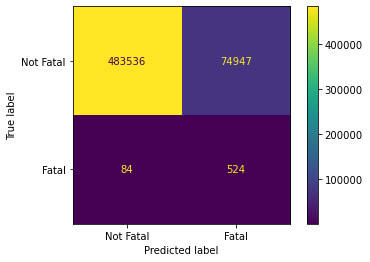

In [37]:
plot_confusion_matrix(log_model, X_train, y_train, labels = ['Not Fatal', 'Fatal']);

In [38]:
y_train

813775     Not Fatal
1462778    Not Fatal
454772     Not Fatal
207693     Not Fatal
1035345    Not Fatal
             ...    
520822     Not Fatal
731780     Not Fatal
268636     Not Fatal
1337987    Not Fatal
248937     Not Fatal
Name: Fatality Classification, Length: 559091, dtype: object

In [39]:
log_model.classes_

array(['Fatal', 'Not Fatal'], dtype=object)

In [40]:
cv_scores = cross_val_score(estimator = log_model, X=X_train, y=y_train, scoring = recall_scorer, n_jobs=4).mean()
cv_scores

KeyboardInterrupt: 

In [44]:
sm = SMOTE(random_state=42, sampling_strategy = 0.1)

X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)



In [ ]:
log_model_smote = logreg.fit(X_train_smote, y_train_smote)

y_true_smote = y_train_smote
y_pred_smote = log_model_smote.predict(X_train_smote)

print("Training recall: ", recall_score(y_true_smote, y_pred_smote, pos_label = 'Fatal'))

In [ ]:
cv_scores_smote = cross_val_score(estimator = log_model_smote, X=X_train_smote, y=y_train_smote, 
                                  scoring = recall_scorer, n_jobs = -1).mean()
cv_scores_smote

In [ ]:
log_model_smote.coef_

## Decision Tree Model

In [41]:
#normal decision tree model
clf = DecisionTreeClassifier(criterion='gini', random_state=42, class_weight = 'balanced', max_depth = 24, min_samples_split = 5000)

clf.fit(X_train, y_train)

y_preds = clf.predict(X_train)

print('Recall: ', recall_score(y_train, y_preds, pos_label = 'Fatal'))

#smote decision tree model


Recall:  0.962171052631579


In [42]:
cv_score_tree = cross_val_score(estimator = clf, X=X_train, y=y_train, scoring = recall_scorer, n_jobs=-1).mean()
cv_score_tree

KeyboardInterrupt: 

In [45]:
clf_smote = DecisionTreeClassifier(criterion='gini', random_state=42, class_weight = 'balanced', max_depth = 24,
                                   min_samples_split = 2500)

clf_smote.fit(X_train_smote, y_train_smote)

y_preds_smote = clf_smote.predict(X_train_smote)

print('Recall: ', recall_score(y_train_smote, y_preds_smote, pos_label = 'Fatal'))

Recall:  0.9757556224036671


In [ ]:
cv_smote_tree = cross_val_score(estimator = clf_smote, X=X_train_smote, y=y_train_smote, scoring = recall_scorer,
                                n_jobs=-1).mean()
cv_smote_tree

In [46]:
feature_importance = clf_smote.feature_importances_
feature_importance

array([0.00000000e+00, 1.82575839e-03, 2.28286090e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.09686798e-07, 0.00000000e+00,
       0.00000000e+00, 5.64372377e-04, 6.21422497e-06, 0.00000000e+00,
       2.12618669e-03, 0.00000000e+00, 0.00000000e+00, 4.17844278e-03,
       0.00000000e+00, 1.11048752e-03, 1.95648859e-17, 5.52484843e-04,
       2.21817945e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.73007056e-04, 3.26201742e-03, 7.16986528e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.21422721e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.99551614e-04, 7.59228920e-04,
       0.00000000e+00, 1.84816893e-05, 4.16393365e-03, 1.56771813e-18,
       0.00000000e+00, 0.00000000e+00, 5.35481588e-04, 0.00000000e+00,
       0.00000000e+00, 7.84526748e-04, 0.00000000e+00, 1.56615350e-03,
       0.00000000e+00, 1.28273973e-02, 8.56678839e-05, 2.20067072e-03,
      

In [ ]:
categorical_encoded.columns

In [47]:
feature_importances = pd.Series(list(feature_importance), name = 'feature_importance')
features = pd.Series(list(categorical_encoded), name = 'features')


In [48]:
features

0                                        x0_BLOWING SNOW
1                                               x0_CLEAR
2                                     x0_CLOUDY/OVERCAST
3                                      x0_FOG/SMOKE/HAZE
4                               x0_FREEZING RAIN/DRIZZLE
                             ...                        
233                             x13_TURNING RIGHT ON RED
234                              x13_UNABLE TO DETERMINE
235    x13_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE ...
236    x13_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDI...
237                                          x13_WEATHER
Name: features, Length: 238, dtype: object

In [49]:
feature_importances

0      0.000000
1      0.001826
2      0.002283
3      0.000000
4      0.000000
         ...   
233    0.000000
234    0.002748
235    0.000642
236    0.000000
237    0.000000
Name: feature_importance, Length: 238, dtype: float64

In [50]:
features_df = pd.DataFrame([feature_importances, features]).transpose()

In [51]:
features_df

,feature_importance,features
0,0,x0_BLOWING SNOW
1,0.00182576,x0_CLEAR
2,0.00228286,x0_CLOUDY/OVERCAST
3,0,x0_FOG/SMOKE/HAZE
4,0,x0_FREEZING RAIN/DRIZZLE
...,...,...
233,0,x13_TURNING RIGHT ON RED
234,0.00274765,x13_UNABLE TO DETERMINE
235,0.000641942,x13_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE ...
236,0,"x13_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDI..."


In [52]:
features_df.sort_values(by='feature_importance', inplace=True, ascending=False)

In [53]:
features_df.head(15)

,feature_importance,features
144,0.230669,x11_FIXED OBJECT
151,0.188903,x11_PEDESTRIAN
165,0.0987349,x12_DISREGARDING TRAFFIC SIGNALS
189,0.0747491,x12_PHYSICAL CONDITION OF DRIVER
138,0.0586905,"x10_DARKNESS, LIGHTED ROAD"
145,0.0432509,x11_HEAD ON
150,0.0327099,x11_PEDALCYCLIST
77,0.0240618,x7_DIVIDED - W/MEDIAN (NOT RAISED)
81,0.0186915,x7_FOUR WAY
73,0.0141725,x6_21


## Testing data

In [ ]:
y_preds_test = clf_smote.predict(X_test)
print('Recall: ', recall_score(y_test, y_preds_test, pos_label = 'Fatal'))

In [ ]:
y_pred_test = log_model_smote.predict(X_test)

print("Training recall: ", recall_score(y_test, y_pred_test, pos_label = 'Fatal'))

## Feature Importance Analysis

In [103]:
#Check to see if indices align
X.head()

,x0_BLOWING SNOW,x0_CLEAR,x0_CLOUDY/OVERCAST,x0_FOG/SMOKE/HAZE,x0_FREEZING RAIN/DRIZZLE,x0_OTHER,x0_RAIN,x0_SEVERE CROSS WIND GATE,x0_SLEET/HAIL,x0_SNOW,...,x13_PHYSICAL CONDITION OF DRIVER,x13_RELATED TO BUS STOP,x13_ROAD CONSTRUCTION/MAINTENANCE,x13_ROAD ENGINEERING/SURFACE/MARKING DEFECTS,x13_TEXTING,x13_TURNING RIGHT ON RED,x13_UNABLE TO DETERMINE,x13_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"x13_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",x13_WEATHER
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
#Check to see if indices align
y.head()

0    Not Fatal
1    Not Fatal
2    Not Fatal
3    Not Fatal
4    Not Fatal
Name: Fatality Classification, dtype: object

In [78]:
#reset y index so can merge with X on the index
y.reset_index(drop = True, inplace = True)

In [105]:
#Confirm reset was successful
y.head()

0    Not Fatal
1    Not Fatal
2    Not Fatal
3    Not Fatal
4    Not Fatal
Name: Fatality Classification, dtype: object

In [80]:
#Merge dfs to be able to perform calculations with all data together
categorical_and_fatal_df = X.merge(y, left_index = True, right_index = True, how = 'right')

In [106]:
X.shape

(745455, 238)

In [107]:
y.shape

(745455,)

In [108]:
#Confirm merge was successful. Should have same # of rows as before with one more column than X
categorical_and_fatal_df.shape

(745455, 239)

In [112]:
#Function takes in a dataframe and relevant columns.
#Function loops through each column, calculating the percentage of Fatalities for each column's involvment in crashes
#Function outputs a dataframe with column names and their Fatality Percentage in descending order
def calc_percentage(df, columns):
    
    percent_dict = {}
    
    for col in columns:    
        #Calculate percentage
        col_perc = len(df.loc[(df[col]==1) & (df['Fatality Classification']=='Fatal')]) / len(df.loc[df[col]==1])
        #Add percentage to dictionary
        percent_dict[col] = col_perc
    #Convert dictionary to DataFrame
    percent_df = pd.DataFrame.from_dict(percent_dict, orient='index', columns=['Fatality Percentage'])
    percent_df.sort_values(by = 'Fatality Percentage', ascending = False, inplace = True)
    
    return percent_df

In [113]:
relevant_columns = features_df['features'].unique()[:15].tolist() #enter column names we want to analyze the percentage of
feature_fatal_percent_df = calc_percentage(categorical_and_fatal_df, relevant_columns)
feature_fatal_percent_df

,Fatality Percentage
x12_PHYSICAL CONDITION OF DRIVER,0.016615
x11_PEDESTRIAN,0.011916
x12_EXCEEDING AUTHORIZED SPEED LIMIT,0.010736
x11_HEAD ON,0.006110
x11_FIXED OBJECT,0.005798
x12_DISREGARDING TRAFFIC SIGNALS,0.004203
x6_1,0.004075
x11_PEDALCYCLIST,0.002859
"x10_DARKNESS, LIGHTED ROAD",0.002516
x6_21,0.002087


In [111]:
#x6 is Crash Hour, 1 corresponding to 1pm and 21 corresponding to 9pm
vehicles_crashes_df['Crash Hour'].value_counts()

15    57498
16    57128
17    55695
14    50218
18    46006
13    45610
12    43956
8     39056
11    37949
9     34173
10    33942
19    33796
7     31090
20    27179
21    24433
22    22407
23    19411
0     16101
6     16021
1     13741
2     11788
5     10113
3      9580
4      8564
Name: Crash Hour, dtype: int64

In [114]:
#Output df to csv for graph making in Tableau
feature_fatal_percent_df.to_csv('../data/localdata/feature_fatal_percent.csv', index=False)